In [1]:
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

# For better printing
pd.options.display.max_colwidth = 100

# <span style="color:darkorange">Availability Bias</span>

#### Importing + Preprocessing data

In [2]:
# Minimum number of reviewers for a PR
min_reviewer_num = 3

avail_data_path = 'availability_data_set.csv'
avail_data = pd.read_csv(avail_data_path, index_col = [0])
avail_data_frame = pd.DataFrame(avail_data)

# Creating a Reviewers.csv file for Anchoring bias analysis
reviewers = list(avail_data_frame['reviewer'].unique())
reviewers_df = pd.DataFrame(reviewers, columns=['reviewer'])
reviewers_df.to_csv('Reviewers.csv')

In [40]:
# Removing duplicates if it is appeared during data mining
avail_data_frame = avail_data_frame.drop_duplicates(subset = ["review_comment_body", "review_comment_URL"])

# Removing PR without min number of reviewers
df = avail_data_frame.groupby('pr_id')['reviewer'].nunique()
unique_pr_id = list(df.index)

for Id in unique_pr_id:
    if int(df[df.index == Id]) < min_reviewer_num:
        index_names = avail_data_frame[avail_data_frame['pr_id'] == Id].index
        avail_data_frame.drop(index_names, inplace = True)

#### Sampling

##### Approach 1 (Simple Random Sampling on PRs)

In [41]:
# confidence interval(%)
CI = 15

# Sample size calculation
n_prime = (1.96**2)*50*(100-50)/(CI**2)
N = len(np.unique(avail_data_frame['pr_id']))
sample_size = ceil(N*n_prime/(N + n_prime))

# Printing number of samples
print('{} PRs as random sample | Confidence Level = 95% | Confidence Interval = {}%.'.format(sample_size, CI))

38 PRs as random sample | Confidence Level = 95% | Confidence Interval = 15%.


In [42]:
# Extracting unique elements of pr_id
unique_pr_id = np.unique(avail_data_frame['pr_id'])

# Shuffling
np.random.shuffle(unique_pr_id)

# PR id random sampling
pr_sample = np.random.choice(unique_pr_id, sample_size, replace = False)

# Saving the sampled dataset
avail_random_sample = pd.DataFrame()

for pr in pr_sample:
    new_rows = avail_data_frame[avail_data_frame['pr_id'] == pr]
    avail_random_sample = avail_random_sample.append(new_rows, ignore_index=True) 

##### Approach 2 (based on Repos + PRs)

In [ ]:
# First take random sample from Repos
unique_Repos = np.unique(avail_data_frame['Repo'])
np.random.shuffle(unique_Repos)
Repo_sample = np.random.choice(unique_Repos, sample_size, replace = False)

# Saving the sampled dataset
avail_random_sample2 = pd.DataFrame()

# Then for each sampled Repo, we randomly take one of its PR as a final sample
for Repo in Repo_sample:
    all_PRs = avail_data_frame[avail_data_frame['Repo'] == Repo]
    sampled_pr_id = np.random.choice(np.unique(all_PRs['pr_id']))
    new_rows = all_PRs[all_PRs['pr_id'] == sampled_pr_id]
    avail_random_sample2 = avail_random_sample2.append(new_rows, ignore_index=True)

#### Rearranging + Saving the sampled dataset

In [44]:
# Rearraging dataset rows (group by ['pr_id', 'path']) 
grouped_persons = avail_random_sample.groupby(['pr_id', 'path'], sort=False, as_index=False)

modified_avail_random_sample = pd.DataFrame()
for key, item in grouped_persons:
    new_rows = grouped_persons.get_group(key)
    modified_avail_random_sample = modified_avail_random_sample.append(new_rows, ignore_index=True)

# Saving
df = pd.DataFrame(modified_avail_random_sample)
df.to_csv('avail_random_sample.csv')

In [45]:
# Printing all sampled dataset
grouped_df = modified_avail_random_sample.groupby('pr_id', sort=False, as_index=False)['review_comment_URL']

for key, item in grouped_df:
    print('########## PR id : {} ##########'.format(key))
    print(grouped_df.get_group(key), "\n\n")

########## PR id : 70101961 ##########
0    https://github.com/apache/tinkerpop/pull/314#discussion_r64039957
1    https://github.com/apache/tinkerpop/pull/314#discussion_r64040220
2    https://github.com/apache/tinkerpop/pull/314#discussion_r65378682
Name: review_comment_URL, dtype: object 


########## PR id : 451281591 ##########
3     https://github.com/apache/hive/pull/1275#discussion_r457970694
4     https://github.com/apache/hive/pull/1275#discussion_r457977709
5     https://github.com/apache/hive/pull/1275#discussion_r458001001
6     https://github.com/apache/hive/pull/1275#discussion_r458027913
7     https://github.com/apache/hive/pull/1275#discussion_r458136670
8     https://github.com/apache/hive/pull/1275#discussion_r458609685
9     https://github.com/apache/hive/pull/1275#discussion_r458609954
10    https://github.com/apache/hive/pull/1275#discussion_r458610811
11    https://github.com/apache/hive/pull/1275#discussion_r458611187
12    https://github.com/apache/hive/pull/12

#### Investigating the Manually Analysed Result

In [63]:
# A threshold (%) for existance of avail bias for one reviewer
avail_thres = 50

In [64]:
reviewer_CommNum = {}
unique_pr_id = np.unique(avail_random_sample['pr_id'])

for PR in unique_pr_id:
    grouping = avail_random_sample[avail_random_sample['pr_id'] == PR].groupby(['original_position', 'path'], sort=False, as_index=False)
    for key, item in grouping:
        new_rows = grouping.get_group(key)
        for rev in np.unique(list(new_rows['reviewer'])):
            if rev not in reviewer_CommNum:
                reviewer_CommNum[rev] = 1

            else:
                reviewer_CommNum[rev] += 1

In [65]:
reviewer_CommNum

{'sahilTakiar': 8,
 'liyinan926': 1,
 'suvodeep-pyne': 4,
 'dkuppitz': 1,
 'okram': 1,
 'spmallette': 3,
 'mstoodle': 1,
 'llxia': 33,
 'charliegracie': 3,
 'dmitripivkine': 5,
 'keithc-ca': 126,
 'AdamBrousseau': 8,
 'JasonFengJ9': 20,
 'pshipton': 32,
 'DanHeidinga': 30,
 'pdbain-ibm': 1,
 'andrewcraik': 9,
 'fjeremic': 39,
 'mpollmeier': 2,
 'robertdale': 1,
 'smlambert': 7,
 'newkek': 1,
 'FlorianHockmann': 3,
 'jorgebay': 4,
 'matthiasblaesing': 8,
 'sdedic': 1,
 'JaroslavTulach': 1,
 'renfeiw': 7,
 'graemerocher': 19,
 'jameskleeh': 5,
 'JeroenMinnaert': 2,
 'todoubaba': 1,
 'Willsparker': 1,
 'sxa': 1,
 'junichi11': 2,
 'lkishalmi': 3,
 'codefromthecrypt': 1,
 'violetagg': 3,
 'simonbasle': 5,
 'r30shah': 6,
 'mpirvu': 10,
 'dsouzai': 3,
 'pvary': 5,
 'belugabehr': 1,
 'deniskuzZ': 15,
 'sankarh': 5,
 'tajila': 25,
 'gacholio': 40,
 'ChengJin01': 1,
 'RSalman': 1,
 'amicic': 15,
 'dnakamura': 3,
 'dchopra001': 1,
 'jlahoda': 1,
 'zl-wang': 7,
 'gita-omr': 1,
 'arjun4084346': 7,


# <span style="color:darkorange">Anchoring Bias</span>

In [4]:
anchor_data_path = 'anchoring_data_set.csv'
anchor_data = pd.read_csv(anchor_data_path, index_col = [0])
anchor_data_frame = pd.DataFrame(anchor_data)

# Removing duplicates if it is appeared during data mining
anchor_data_frame = anchor_data_frame.drop_duplicates(subset = ["review_comment_body", "review_comment_URL"])

# Remove reviewers which don't pass number of comments threshold
threshold = 2

g = anchor_data_frame.groupby(['reviewer']).agg({'review_comment_id': 'nunique'})
for reviewer in g.index:
    comment_number = int(g[g.index == reviewer]['review_comment_id'])
    if comment_number < threshold:
        anchor_data_frame.drop(anchor_data_frame[anchor_data_frame['reviewer'] == reviewer].index, inplace = True)

c:\users\emad\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


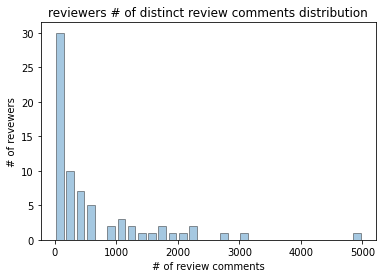

In [3]:
# Visualizing the dataset
reviewer_uniq_comments = anchor_data_frame.groupby(['reviewer']).agg({'review_comment_id': 'nunique'})

sns.distplot(reviewer_uniq_comments, hist=True, kde = False, bins = 30, 
            hist_kws={"rwidth":0.75,'edgecolor':'black'})
plt.xlabel("# of review comments")
plt.ylabel("# of revewers")
plt.title("reviewers # of distinct review comments distribution")
plt.show()

#### Sampling

In [4]:
def SRS_size(CI, N, deff = 1):
    n_prime = (1.96**2)*50*(100-50)/(CI**2)
    sample_size = ceil(deff*N*n_prime/(N + n_prime))
    return sample_size

##### Method: Two Stage Stratified Random Sampling

This method should be used when number of reviewers in the dataset reaches a reasonable level.

In [5]:
# confidence interval(%)
CI = 10

# Proportionate Stratified Sampling design effect
deff = 1.3

# Sample size calculation
N = sum(list(reviewer_uniq_comments['review_comment_id']))
sample_size = SRS_size(CI, N, deff)

# Sample rate for each strata
sample_rate = 100*sample_size/N

# Printing number of samples
print('Sample rate = {}% of review comnts for each reviewer | Confidence Level = 95% | Confidence Interval = {}%.'
      .format(round(sample_rate, 2), CI))

Sample rate = 0.3% of review comnts for each reviewer | Confidence Level = 95% | Confidence Interval = 10%.


With this sample rate for a reviewer with 1000 comments we need to sample 3 comments to reach Confidence Level = 95% and Confidence Interval = 10%. For reviewers that have less than 1000 comments if we sample greater than 3 comments, we do not harm the final results of confidence level or interval. Thus for reviewers with # of comments > 1000 we use the above sample rate, and for other reviewers we take 10 random comments as sample.

First using SRS take a sample of reviewers. Then for each reviewer take the following disproportionate sampling approach:
- for reviewers with <10 comments => select all comments
- for reviewers with 10< < 1000 comments => select 10 random comments
- for reviewers with > 1000 comments => consider the above sampling rate



##### First Stage (Simple Random Sampling for reviewers)

In [8]:
# Sample size
N = len(np.unique(anchor_data_frame['reviewer']))
reviewer_sample_size = SRS_size(CI, N)

# Simple Random Sample
uniq_reviewers = np.unique(anchor_data_frame['reviewer'])
reviewer_list = np.random.choice(uniq_reviewers, reviewer_sample_size, replace = False)

##### Second Stage (Stratified Random Sampling)

In [9]:
anchor_random_sample = pd.DataFrame()

for Reviewer in reviewer_list:
    comments = anchor_data_frame[anchor_data_frame['reviewer'] == Reviewer]
    
    if len(comments) >= 1000:
        sampled_comments = comments.sample(frac = sample_rate/100)
        anchor_random_sample = anchor_random_sample.append(sampled_comments, ignore_index=True)
        
    elif 10 < len(comments) < 1000:
        sampled_comments = comments.sample(n = 10)
        anchor_random_sample = anchor_random_sample.append(sampled_comments, ignore_index=True)
        
    else:
        anchor_random_sample = anchor_random_sample.append(comments, ignore_index=True)

In [55]:
# Printing all sampled dataset
grouped_df = anchor_random_sample.groupby('reviewer', sort=False, as_index=False)['review_comment_URL']

for key, item in grouped_df:
    print('########## Reviewer : {} ##########'.format(key))
    print(grouped_df.get_group(key), "\n\n")

########## Reviewer : mweirauch ##########
0    https://github.com/mweirauch/micrometer-jvm-extras/pull/175#discussion_r877561472
1                  https://github.com/Mercateo/factcast/pull/409#discussion_r281319651
2                  https://github.com/Mercateo/factcast/pull/409#discussion_r281318948
3                  https://github.com/Mercateo/factcast/pull/403#discussion_r279166194
4                  https://github.com/Mercateo/factcast/pull/167#discussion_r226873691
5                  https://github.com/Mercateo/factcast/pull/403#discussion_r279166310
6                  https://github.com/Mercateo/factcast/pull/388#discussion_r280765290
7                  https://github.com/Mercateo/factcast/pull/216#discussion_r234439660
8    https://github.com/mweirauch/micrometer-jvm-extras/pull/175#discussion_r877568091
9    https://github.com/mweirauch/micrometer-jvm-extras/pull/175#discussion_r877561249
Name: review_comment_URL, dtype: object 


########## Reviewer : anuraaga ##########
10

In [56]:
# Saving
df = pd.DataFrame(anchor_random_sample)
df.to_csv('anchor_random_sample.csv')

#### Investigating the Manually Analysed Result

In [6]:
# A threshold (%) for existance of anchor bias for one reviewer
anchor_thres = 50

In [10]:
reviewer_CommNum = {}
grouping = anchor_random_sample.groupby(['reviewer']).agg({'review_comment_id': 'nunique'})

for rev in grouping.index:
    Reviewer_Comm = int(grouping[grouping.index == rev]['review_comment_id'])
    reviewer_CommNum[rev] = Reviewer_Comm

In [11]:
reviewer_CommNum

{'OleksiiBondar': 10,
 'RikJansen81': 2,
 'SergeyKanzhelev': 7,
 'SplotyCode': 2,
 'YuliaFrishko': 3,
 'aleksandy': 6,
 'alvarosanchez': 10,
 'anuraaga': 7,
 'ben-manes': 10,
 'benmccann': 8,
 'burtbeckwith': 10,
 'countableSet': 4,
 'davidkarlsen': 10,
 'dhaval24': 10,
 'eogren': 10,
 'eskatos': 3,
 'ggonchar': 4,
 'graemerocher': 5,
 'htran1': 10,
 'ivansenic': 5,
 'jameskleeh': 10,
 'jinhyukchang': 10,
 'jkschneider': 10,
 'john-karp': 4,
 'jonatan-ivanov': 10,
 'lgathy': 8,
 'lukaseder': 10,
 'michaelandrepearce': 3,
 'milgner': 10,
 'mweirauch': 10,
 'pirgeo': 10,
 'simonbasle': 6,
 'slomo': 10,
 'spencergibb': 4,
 'trustin': 15,
 'twicksell': 10,
 'victornoel': 4,
 'violetagg': 10,
 'vladimir-bukhtoyarov': 3,
 'wetted': 10,
 'ydai1124': 10}